In [1]:
from ceo import constants, StopWatch
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


# WFPT modal control demo with the Probe Zero
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using the full Probe Zero, and modal control.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 07/12/2023

In [2]:
from ceo import wfpt_simul, wfpt_visulib, wfpt_utilities

In [3]:
import importlib
importlib.reload(sys.modules['ceo'])
from ceo import wfpt_simul, wfpt_visulib

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . These are the five core WFPT classes:
1. **wfpt_testbed**. The WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_sh48**. A wrapper class for the "CEO ShackHartmann" class that implements the SH48 model.
4. **wfpt_dfs**. A wrapper class for the "CEO DispersedFringeSensor" class that implements the DFS model.
5. **wfpt_simul**. A system (container) class that puts together all the above components to perform a full propagation (from source to probe zero signals).

These are the classes that enable modal control simulation in the WFPT model:
1. **wfpt_zernike_modes_creation**. The class that generates segment Zernike modes fitted by the WFPT actuators (PTT+DM). The main product are the M1 and M2 M2C matrices.
2. **wfpt_modes**. The class that interfaces with the WFPT model to control it with modes.

In [4]:
M2_baffle_diam=0.0#3.6  # size of M2 baffle
project_truss_onaxis=False # simulate truss shadows over central segment
star_mag = 16.0
keep_segments = [1,2,3,4,5,6,7]
wfpt = wfpt_simul(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis,
                 shs_mag=star_mag, dfs_mag=star_mag, keep_segments=keep_segments)

ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA
SH48 pixel scale: 0.321 arcsec
ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA


The **calibrate_sensors** method calibrates the reference measurement vectors for both SH and DFS

In [5]:
%%time

#-- Change FWHM of source (set fwhm=0 for DL source)
#wfpt.shs_src.fwhm = 0

wfpt.calibrate_sensors()

SH source FWHM: 0.642 arcsec
Total SH valid sub-apertures: 1281
SH48 calibration completed.
DFS calibration completed.
CPU times: user 2.06 s, sys: 1.54 s, total: 3.6 s
Wall time: 3.59 s


### Show the WF at the exit pupil

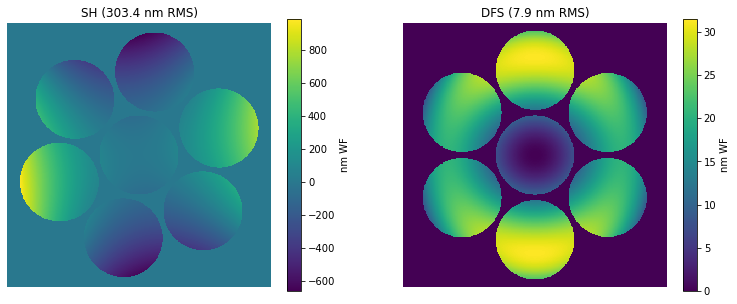

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', subtract_ref_wf=False, fig=fig, ax=ax1)
wfpt.show_wavefront(path='DFS', subtract_ref_wf=False, fig=fig, ax=ax2)

### GMT mask

In [7]:
#---- Retrieve GMT mask
wfpt.reset()
wfpt.shs_path.propagate(wfpt.shs_src)
GMTmask = wfpt.shs_src._gs.amplitude.host().astype('bool')
nmask = np.sum(GMTmask)

In [8]:
segmask = np.array([vec.get() for vec in wfpt.shs_src.piston_mask])
npseg = np.sum(segmask, axis=1).astype('int')

## Initialize WFPT modal control

In [9]:
#--- Load desired M2C matrices from repository.
M1_m2c_file = 'M1_zernikes_M2C_v1.npz'
M2_m2c_file = 'M2_zernikes_M2C_v1.npz'
wfpt.set_modal_control(M1_m2c_file, M2_m2c_file)
nzern = wfpt.modal_control.M1_nmodes

Restoring valid DM actuators from file: M1_zernikes_M2C_v1.npz
Restoring valid DM actuators from file: M2_zernikes_M2C_v1.npz


In [10]:
valid_acts_data = wfpt_utilities.get_dm_valid_actuators( wfpt.modal_control.M1_M2C_data['dm_valid_acts_file'])
valid_acts_data.keys()

Restoring valid DM actuators from file: M1_DM_valid_actuators_with_slaving_v1.npz


dict_keys(['valid_acts', 'n_valid_acts', 'thr', 'act_masters', 'act_slaves', 'slaveMat', 'dm_response_file', 'dm_response_type', 'filename'])

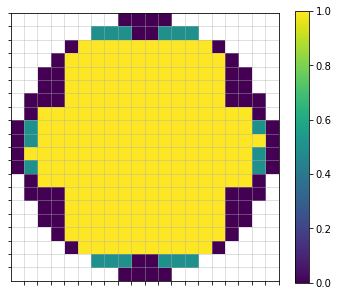

In [11]:
valid_acts_map = valid_acts_data['valid_acts'].astype('float')
valid_acts_map[valid_acts_data['act_slaves']] = 0.5
wfpt_visulib.show_dm292(valid_acts_map)

### Apply and show a segment Zernike mode
Test the application of a given mode to M1 or M2.

In [12]:
wfpt.modal_control.reset()
modal_state1 = wfpt.modal_state
modal_state1['M1']['modes'][0,3] = 1e-6 
modal_state1['M2']['modes'][3,12] = 1e-6
wfpt.modal_update(modal_state1)

CPU times: user 1.4 s, sys: 600 ms, total: 2 s
Wall time: 1.99 s


array([0.9990044 , 0.04417007, 0.07849776, 0.95597214, 0.04839993,
       0.04104092, 0.05236004], dtype=float32)

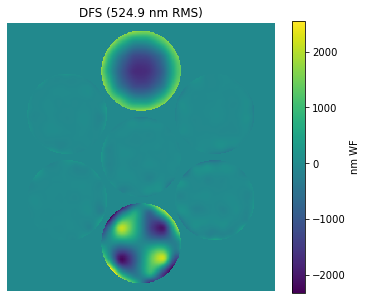

In [13]:
%%time
wfpt.reset_sources()
wfpt.reset_sensors()
wfpt.propagate()
wfpt.show_wavefront(path='DFS')
wfpt.dfs_src.phaseRms(where='segments')*1e6

#### Show WFPT commands

In [14]:
state = wfpt.state
M1_pistvec = state['M1_PTT']['segment piston']
M1_ttvec = state['M1_PTT']['segment tip-tilt']
M1_dmvec = state['M1_DM']['actuators']

M2_pistvec = state['M2_PTT']['segment piston']
M2_ttvec = state['M2_PTT']['segment tip-tilt']
M2_dmvec = state['M2_DM']['actuators']

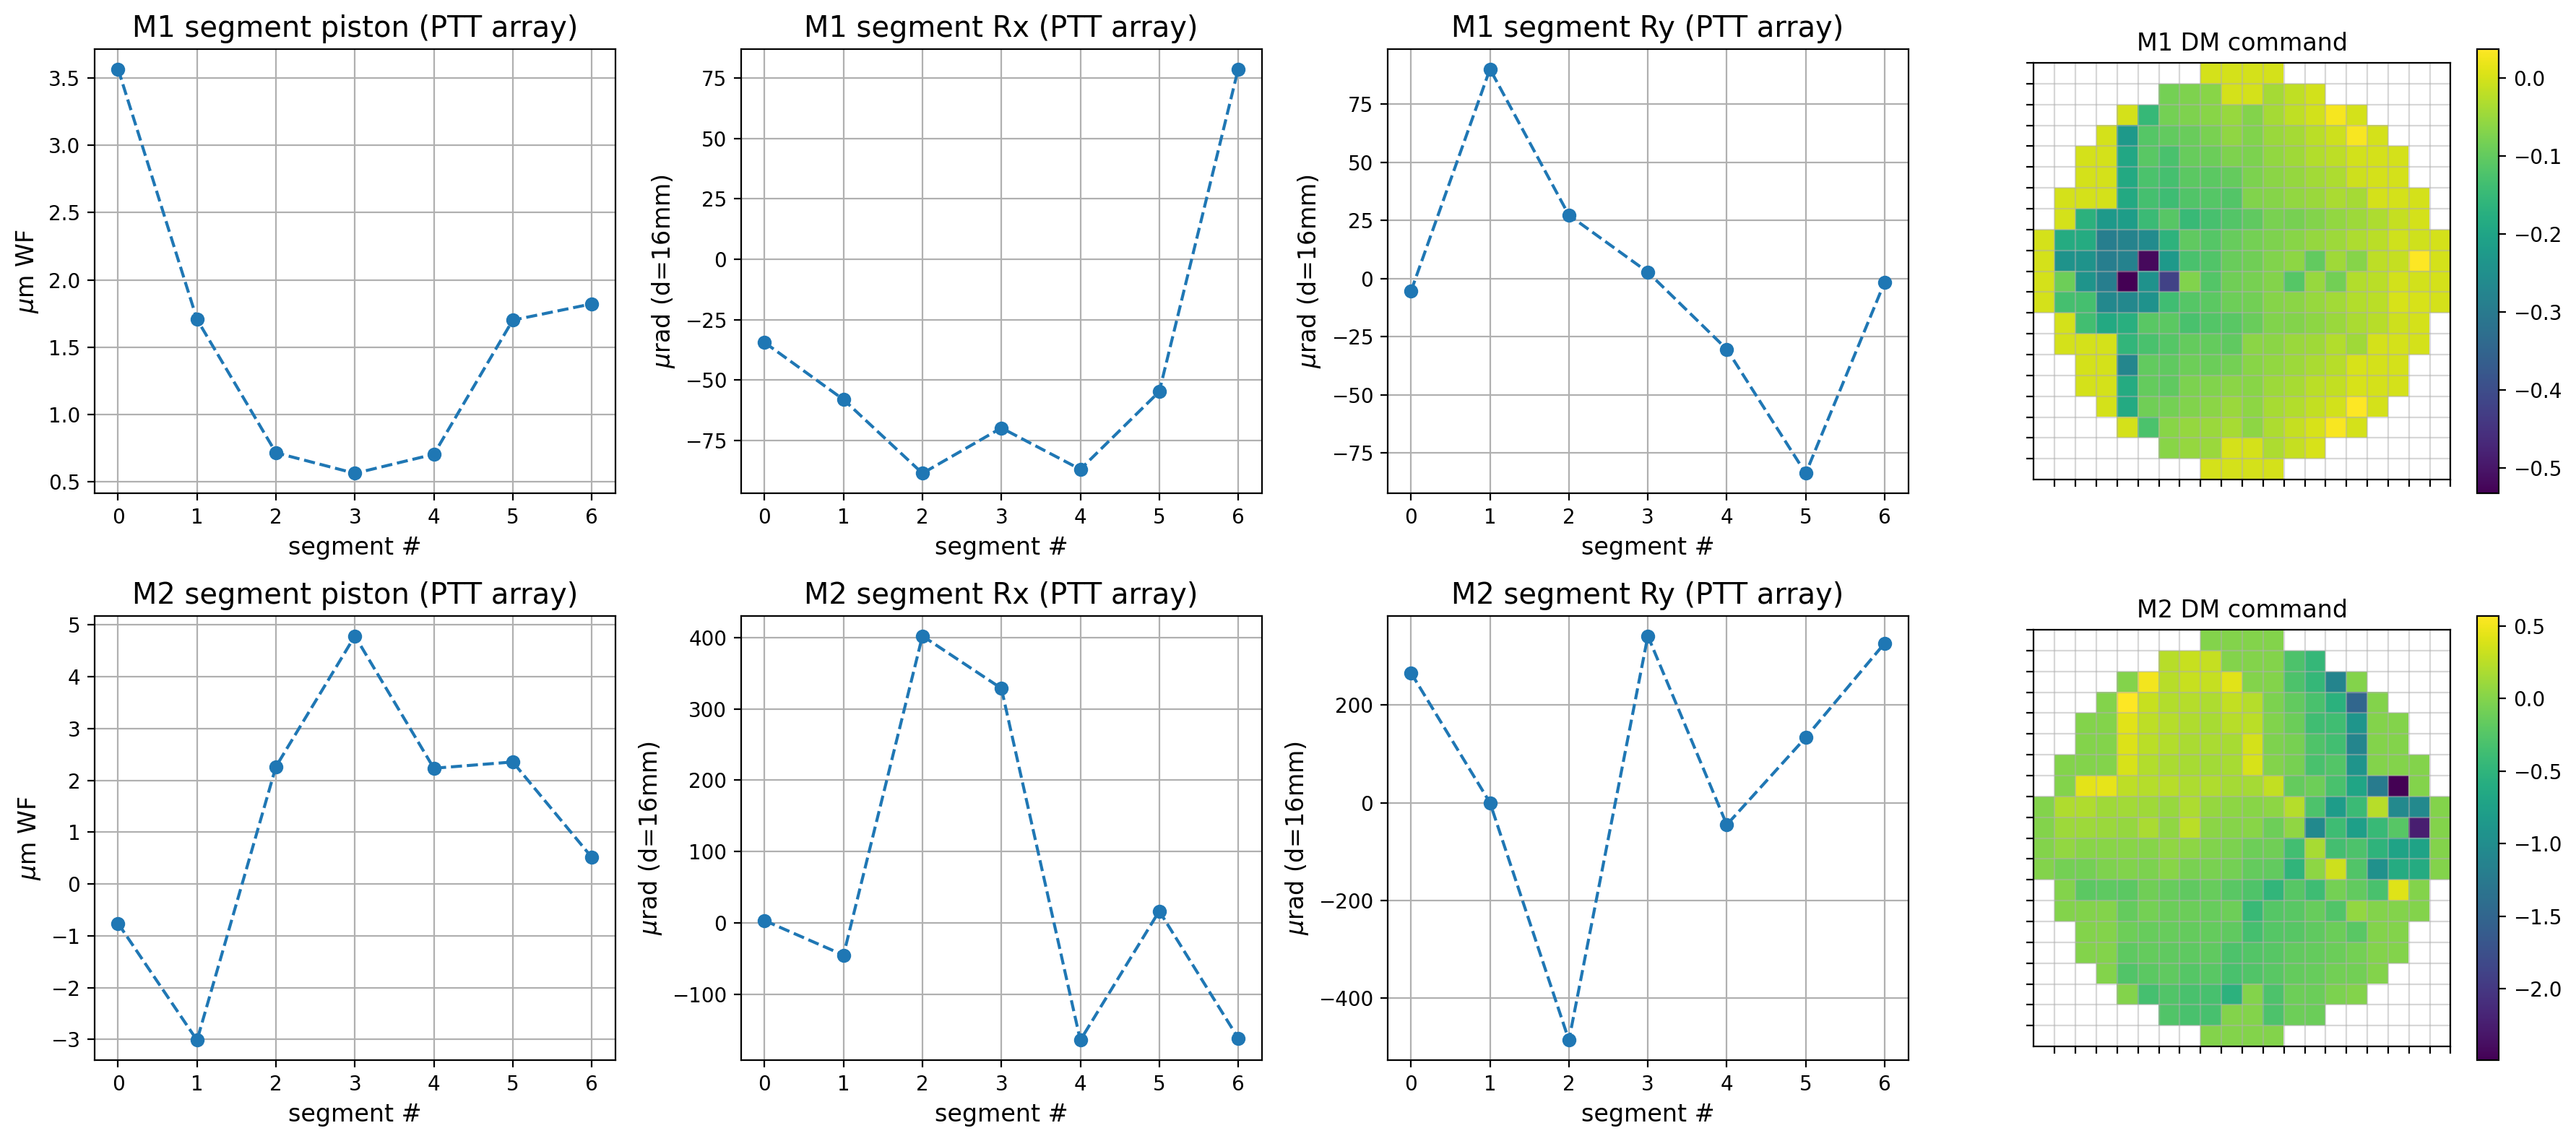

In [15]:
fig, ((ax1, ax2, ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(ncols=4, nrows=2)
fig.set_size_inches((18,8))
fig.dpi=200

ax1.plot(M1_pistvec*1e6, 'o--')
ax1.set_xlabel('segment #', fontsize='large')
ax1.set_ylabel('$\mu$m WF', fontsize='large')
ax1.set_title('M1 segment piston (PTT array)', fontsize='x-large')
ax1.grid()

ax2.plot(M1_ttvec[:,0]*1e6, 'o--')
ax2.set_xlabel('segment #', fontsize='large')
ax2.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax2.set_title('M1 segment Rx (PTT array)', fontsize='x-large')
ax2.grid()

ax3.plot(M1_ttvec[:,1]*1e6, 'o--')
ax3.set_xlabel('segment #', fontsize='large')
ax3.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax3.set_title('M1 segment Ry (PTT array)', fontsize='x-large')
ax3.grid()

wfpt_visulib.show_dm292(M1_dmvec, fig=fig, ax=ax4)
ax4.set_title('M1 DM command');

ax5.plot(M2_pistvec*1e6, 'o--')
ax5.set_xlabel('segment #', fontsize='large')
ax5.set_ylabel('$\mu$m WF', fontsize='large')
ax5.set_title('M2 segment piston (PTT array)', fontsize='x-large')
ax5.grid()

ax6.plot(M2_ttvec[:,0]*1e6, 'o--')
ax6.set_xlabel('segment #', fontsize='large')
ax6.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax6.set_title('M2 segment Rx (PTT array)', fontsize='x-large')
ax6.grid()

ax7.plot(M2_ttvec[:,1]*1e6, 'o--')
ax7.set_xlabel('segment #', fontsize='large')
ax7.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax7.set_title('M2 segment Ry (PTT array)', fontsize='x-large')
ax7.grid()

wfpt_visulib.show_dm292(M2_dmvec, fig=fig, ax=ax8)
ax8.set_title('M2 DM command');

fig.tight_layout()

#### Show SH48 WFS signals

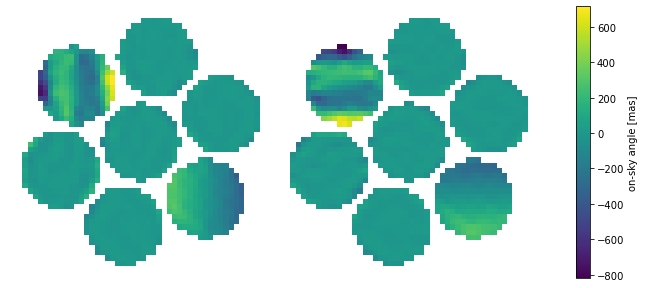

In [16]:
exposureTime = 30.0
wfpt.shs.camera.noiselessReadOut(exposureTime)
#wfpt.shs.readOut(exposureTime)
wfpt.shs.process()

sx2d, sy2d = wfpt.shs.slopes2d()
wfpt_visulib.show_SH_slopes(sx2d*constants.RAD2MAS, sy2d*constants.RAD2MAS, clb_label='on-sky angle [mas]')

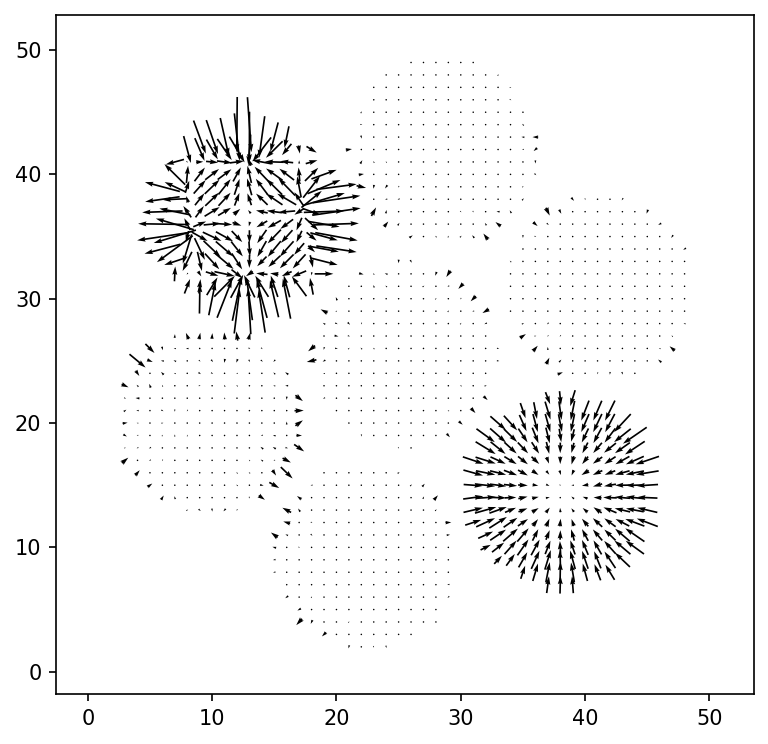

In [17]:
wfpt_visulib.show_SH_quiver(sx2d, sy2d, scale=5e-5)

#### Show DFS measurements

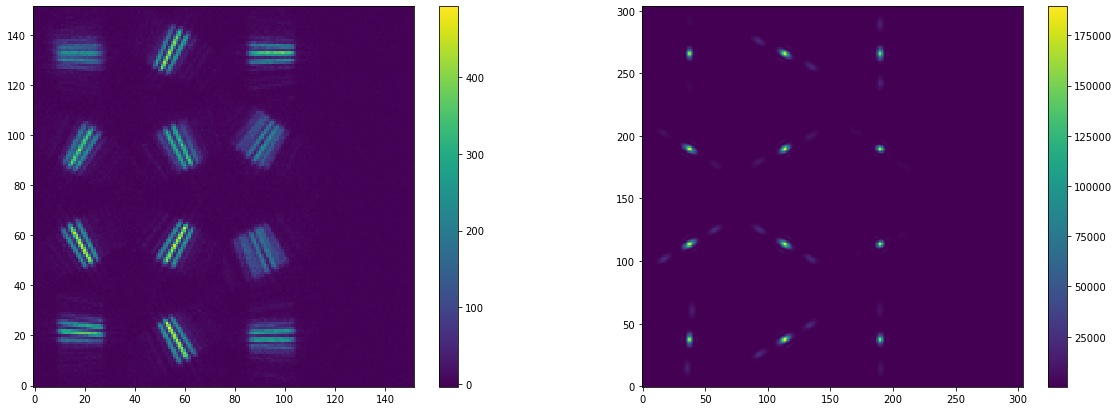

In [18]:
exposureTime = 30.0
#wfpt.dfs.camera.noiselessReadOut(exposureTime)
wfpt.dfs.readOut(exposureTime)
wfpt.dfs.fft()
wfpt.dfs.process()

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(wfpt.dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfpt.dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2)

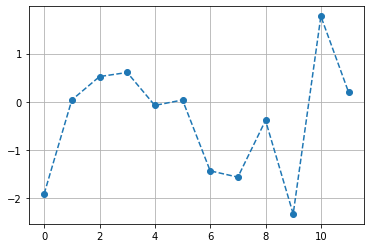

In [19]:
plt.plot(wfpt.dfs.get_measurement(), 'o--')
plt.grid()

## Modal Interaction Matrix Calibration

In [20]:
%%time
D1 = wfpt.interaction_matrix(mirror='M1', modes='modal') 

___ M1 ___ (segment zernikes)
Segment #1: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #2: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #3: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #4: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #5: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #6: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #7: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
------------
___ M1 ___ (segment zernikes)
Segment #1: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #2: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #3: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #4: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #5: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #6: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Segment #7: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
------------
CPU times: user 4min 45s, sys: 2min 17s, total: 7min 3s
Wall time: 7min 2s


In [21]:
M1_DFSsig2pist = D1['M1']['dfs-sig2pist']

### Show interaction matrices with the SH48

(-2.5500000000000003, 53.55, -2.5500000000000003, 53.55)

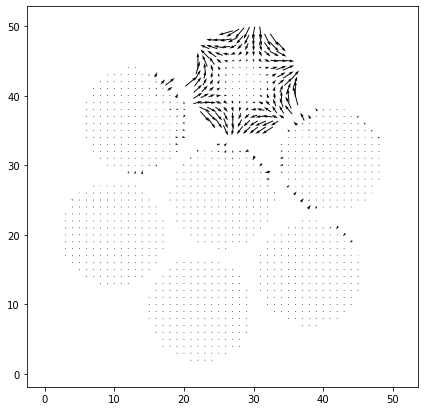

In [22]:
this_seg = 4
this_mode = 8

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
sx2d, sy2d = wfpt.shs.slopes2d(D1['M1']['sh-modes'][:, nzern*this_seg+this_mode])
quiv = ax.quiver(sx2d, sy2d, pivot='mid', scale=5e1)
ax.axis('equal')

### Show interaction matrices with the DFS

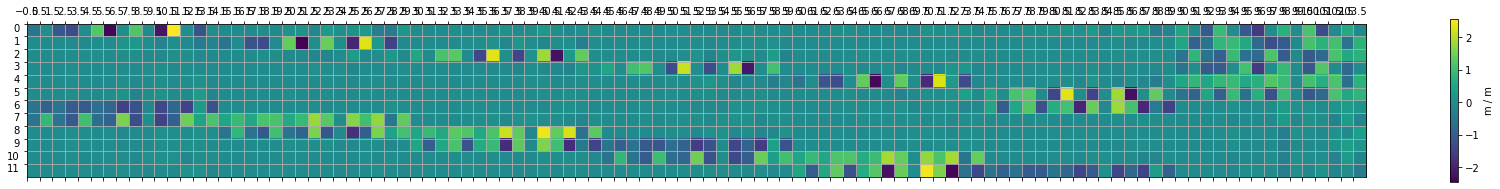

In [23]:
fig2, ax1 = plt.subplots()
fig2.set_size_inches(30,3)
fig.dpi = 1200

im1 = ax1.matshow(M1_DFSsig2pist @ D1['M1']['dfs-modes'])
ax1.grid()
ax1.set_yticks(np.arange(12)-0.5);
ax1.set_yticklabels(np.arange(0,12).tolist(), va='top')
ax1.set_xticks(np.arange(nzern*7)-0.5);
clb1 = fig.colorbar(im1, ax=ax1, label='m / m')
fig.tight_layout()

## Modal reconstructor

### Select modes to control

In [24]:
#-- Remove zernike modes not desired
valid_modes = np.ones(nzern*7, dtype='bool').reshape((7,-1))
valid_modes[:,10] = False #<--- remove spherical (Z11)
valid_modes = np.ravel(valid_modes)

D1_Z_SH = D1['M1']['sh-modes'][:,valid_modes]
D1_Z_DFS = M1_DFSsig2pist @ D1['M1']['dfs-modes'][:,valid_modes]

### Merged interaction matrix

In [25]:
M1_dfs_norm = np.linalg.norm(D1_Z_DFS)
M1_sh_norm = np.linalg.norm(D1_Z_SH)
D1_Z = np.concatenate((D1_Z_DFS/M1_dfs_norm, D1_Z_SH/M1_sh_norm), axis=0)

In [26]:
nmeas = D1_Z.shape[0]

### SVD analysis

M1 segment Zernikes IntMat:
(2574, 98)
conditioning number:
480736.31684082694


Text(0.5, 1.0, 'M1 modal IntMat (on-axis)')

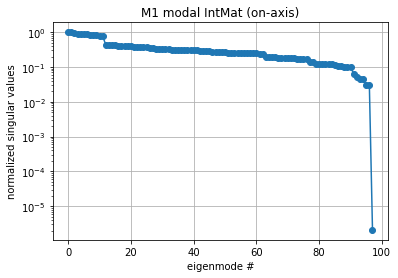

In [27]:
print('M1 segment Zernikes IntMat:')
print(D1_Z.shape)
print("conditioning number:")
print(np.linalg.cond(D1_Z))

UU1, ss1, VVT1 = np.linalg.svd(D1_Z, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 modal IntMat (on-axis)')

#### Show the shape of a particular eigenmode just for fun

In [28]:
this_eigen = -1
eigenmodevec = np.zeros(nzern*7)
eigenmodevec[valid_modes] = np.copy(VVT1[this_eigen,:])

command median value: 0.0000


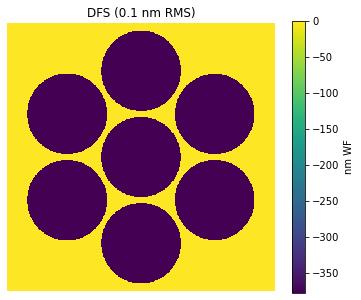

In [29]:
wfpt.reset()
wfpt.modal_control.reset()
modal_state = wfpt.modal_state
modal_state['M1']['modes'] = eigenmodevec.reshape((7,-1)) * 1e-6
wfpt.modal_update(modal_state)

wfpt.dfs_path.propagate(wfpt.dfs_src)
wfpt.show_wavefront(path='DFS')

print("command median value: %0.4f"%(np.median(eigenmodevec)))

### Compute reconstructor
Here the reconstructor is just the generalized inverse

In [30]:
R1_Z = np.zeros((nzern*7, nmeas))
R1_Z[valid_modes,:] = np.linalg.pinv(D1_Z, rcond=1e-3)

### Test reconstructor

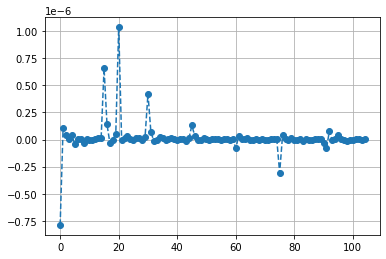

In [32]:
wfpt.reset()
wfpt.modal_control.reset()
modal_state = wfpt.modal_state
modal_state['M1']['modes'][1,5] = 1e-6
wfpt.modal_update(modal_state)

wfpt.propagate()
wfpt.shs.process()
shs_meas = wfpt.shs.get_measurement()
wfpt.dfs.fft()
wfpt.dfs.process()
dfs_meas = M1_DFSsig2pist @ wfpt.dfs.get_measurement()

PZmeas = np.concatenate((dfs_meas/M1_dfs_norm, shs_meas/M1_sh_norm))
M1_comm = R1_Z @ PZmeas

plt.plot(M1_comm, 'o--')
plt.grid()
#plt.xlim([0,30])

### Perform a closed-loop test

#### Introduce a scramble

In [33]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

Global piston [nm]: 35.2
Segment piston [nm]: [-83.3 -57.9 100.3 -30.5  -5.4 158.3 164.3]


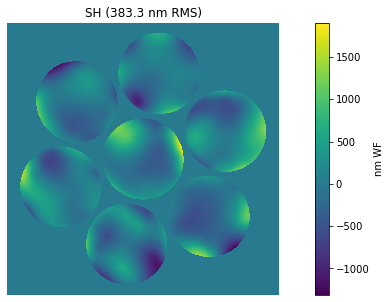

In [61]:
# Scramble:
wfpt.reset()
wfpt.modal_control.reset()

#--- only apply valid modes
modal_scramble = rng.standard_normal(size=(7*nzern)) * 100e-9
modal_scramble[np.logical_not(valid_modes)] = 0

modal_state0 = wfpt.modal_state
modal_state0['M1']['modes'][:] = modal_scramble.reshape((7,-1))
wfpt.modal_update(modal_state0)

# Visualize the scramble
wfpt.shs_src.reset()
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
print("Global piston [nm]: %0.1f"%(wfpt.shs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.shs_src.piston('segments')*1e9,
                                          precision=1))

#### Close the loop

In [62]:
totSimulIter = 30
gain = 0.5
exposureTime = 30.0
wfpt.shs.camera.readOutNoiseRms = 1.0
wfpt.dfs.camera.readOutNoiseRms = 1.0

tid = StopWatch()

M1_comm_buffer = np.zeros(nzern*7)
wfe_iter = np.zeros(totSimulIter)
pist_iter = np.zeros(totSimulIter)
seg_pist_iter = np.zeros((7,totSimulIter))
M1_modes_iter = np.zeros((7,nzern,totSimulIter))

In [63]:
# Get 
wfpt.reset()
wfpt.modal_control.reset()
modal_state = wfpt.modal_state

# Load initial scramble
wfpt.modal_update(modal_state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.shs_src.phaseRms()
    pist_iter[jj] = wfpt.shs_src.piston()
    seg_pist_iter[:,jj] = wfpt.shs_src.piston(where='segments')
    M1_modes_iter[:,:,jj] = np.copy(wfpt.modal_state['M1']['modes'])
    
    #--- WFS measurements and command
    wfpt.shs.readOut(exposureTime)
    wfpt.shs.process()
    shs_meas = wfpt.shs.get_measurement()

    wfpt.dfs.readOut(exposureTime)
    wfpt.dfs.fft()
    wfpt.dfs.process()
    dfs_meas = M1_DFSsig2pist @ wfpt.dfs.get_measurement()

    PZmeas = np.concatenate((dfs_meas/M1_dfs_norm, shs_meas/M1_sh_norm))
    M1_delta_comm = R1_Z @ PZmeas
    M1_comm_buffer += gain * M1_delta_comm
    
    #--- Update state vector
    modal_state['M1']['modes'][:] = -M1_comm_buffer.reshape((7,-1))

    wfpt.modal_update(modal_state0 + modal_state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1931.45, WFE [nm WF RMS] on-axis: 8.85

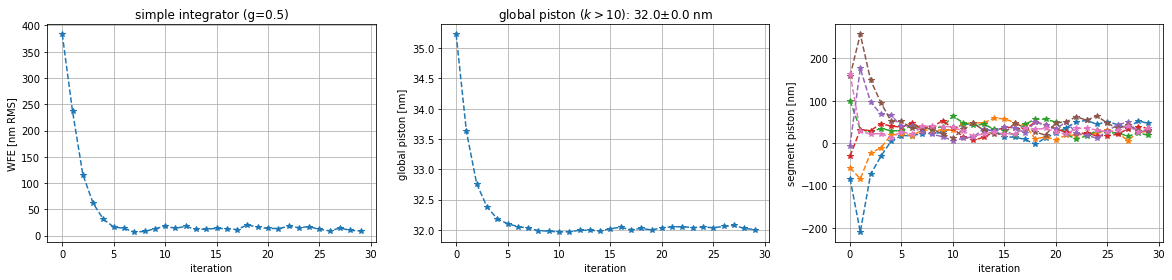

In [64]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches((20,4))

ax1.plot(wfe_iter*1e9, '*--')
ax1.grid()
ax1.set_xlabel('iteration')
ax1.set_title('simple integrator (g=%0.1f)'%gain)
ax1.set_ylabel('WFE [nm RMS]');

ax2.plot(pist_iter*1e9, '*--')
ax2.grid()
ax2.set_xlabel('iteration')
ax2.set_title('global piston ($k>10$): %0.1f$\pm$%0.1f nm'%(np.mean(pist_iter[10:])*1e9,np.std(pist_iter[10:])*1e9))
ax2.set_ylabel('global piston [nm]');

ax3.plot(seg_pist_iter.T*1e9, '*--')
ax3.grid()
ax3.set_xlabel('iteration')
#ax3.set_title('global piston ($k>10$): %0.1f$\pm$%0.1f nm'%(np.mean(pist_iter[10:])*1e9,np.std(pist_iter[10:])*1e9))
ax3.set_ylabel('segment piston [nm]');

Global piston [nm]: 32.0
Segment piston [nm]: [46.6 27.4 18.9 35.8 29.3 30.1 35.9]


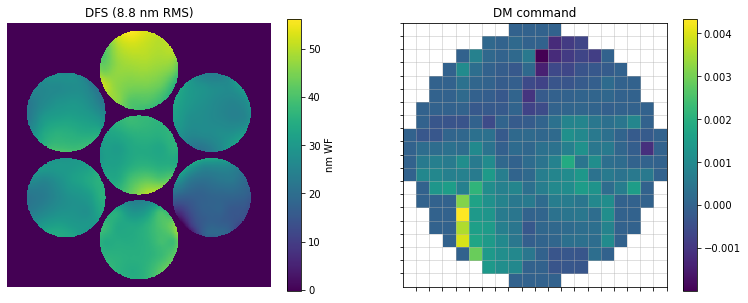

In [65]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='DFS', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(wfpt.state['M1_DM']['actuators'], fig=fig, ax=ax2)
ax2.set_title('DM command');
print("Global piston [nm]: %0.1f"%(wfpt.dfs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.dfs_src.piston('segments')*1e9, precision=1))

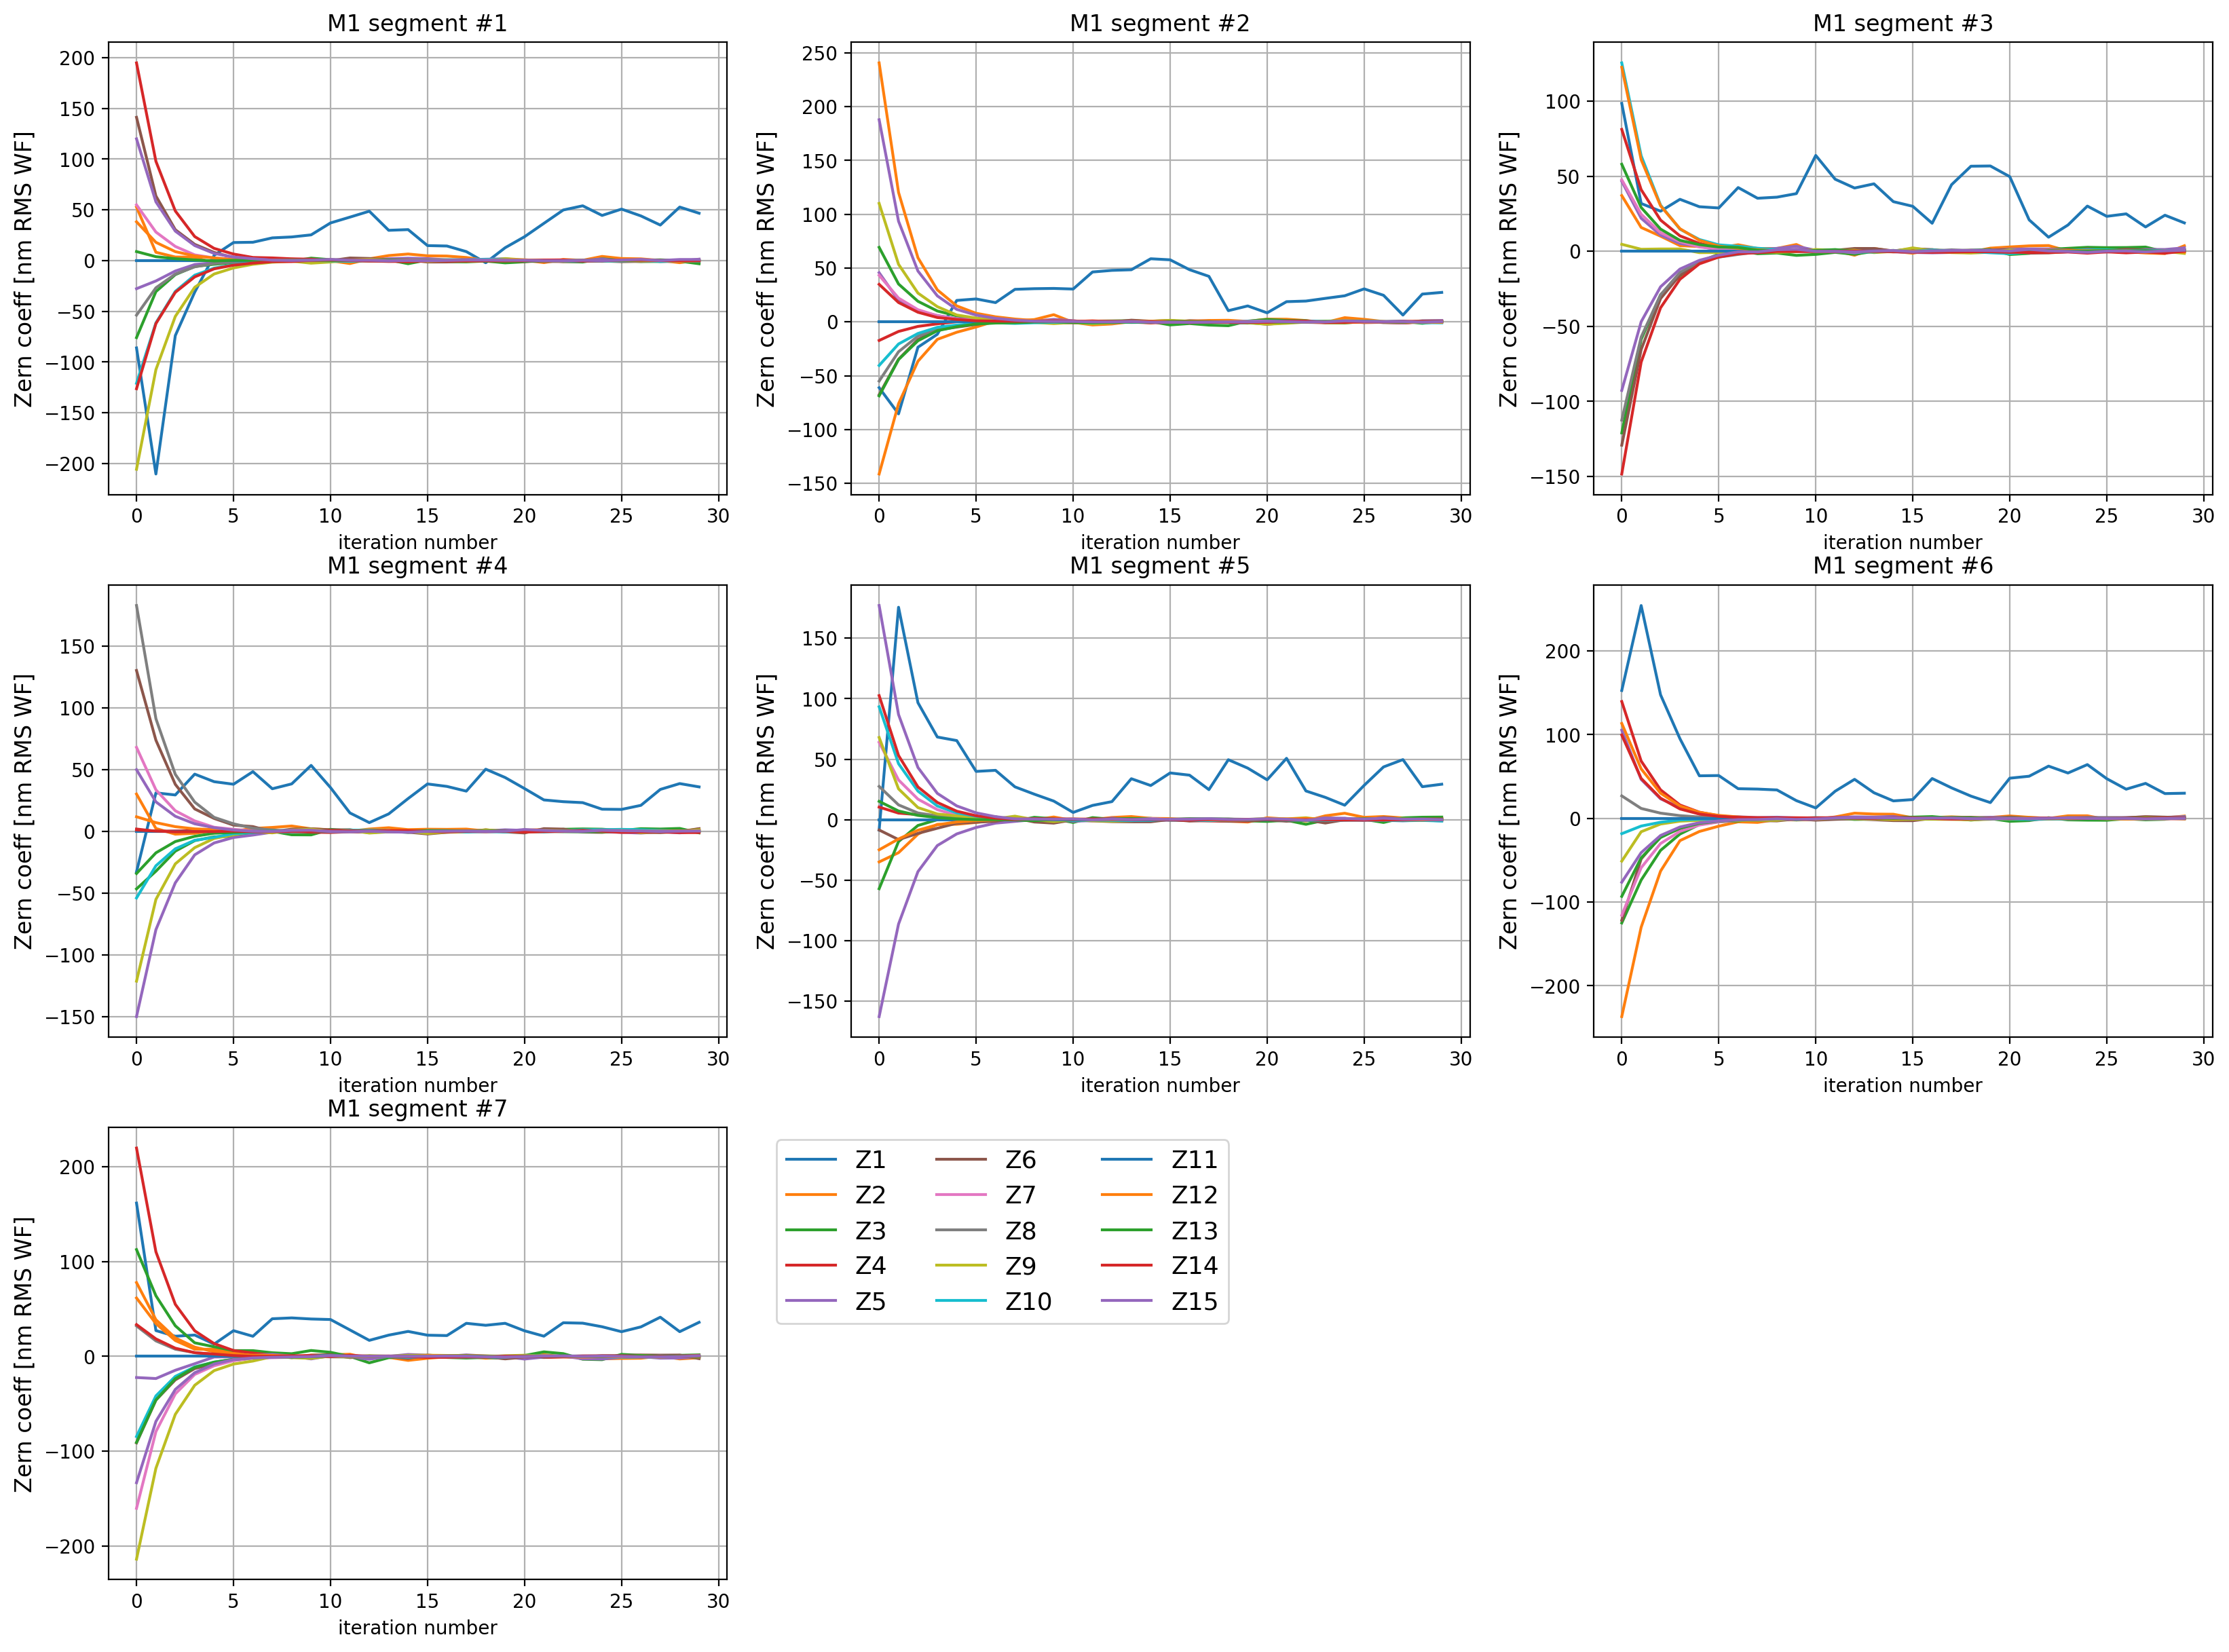

In [69]:
f1, ax = plt.subplots(ncols=3, nrows=3)
f1.set_size_inches(20,15)
f1.dpi = 200
for jj in range(7):
    thisax = (ax.ravel())[jj]
    thisax.plot(M1_modes_iter[jj,:,:].T*1e9)#, '+--')
    thisax.grid()
    thisax.set_title('M1 segment #%d'%(jj+1), size='large')
    thisax.set_xlabel('iteration number')
    thisax.set_ylabel('Zern coeff [nm RMS WF]', size='large')
    #thisax.set_ylim([-200,200])
    #thisax.set_xlim([990,1010])
    
mylegend = ['Z'+str(kk+1) for kk in range(nzern)]
leg_ncols = 3
thisax.legend(mylegend, fontsize=13, bbox_to_anchor=(1.06,1), ncol=leg_ncols)    

for k in range(7,9):
    (ax.ravel())[k].axis('off')